# Detecting COVID-19 in X-ray images with Keras, TensorFlow, and Deep Learning

원 문서 : https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/

PROJECT STRUCTURE

      dataset/
        covid/
        normal/
      build_covid_dataset.py
      sample_kaggle_dataset.py
      train_covid19.py
      plot.png
      covid19.model

# 데이터 준비

In [ ]:
!wget https://github.com/dhrim/pis_study/raw/master/covid_classification/dataset.tar.gz

--2020-07-21 11:34:34--  https://github.com/dhrim/pis_study/raw/master/covid_classification/dataset.tar.gz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/pis_study/master/covid_classification/dataset.tar.gz [following]
--2020-07-21 11:34:35--  https://raw.githubusercontent.com/dhrim/pis_study/master/covid_classification/dataset.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12509198 (12M) [application/octet-stream]
Saving to: ‘dataset.tar.gz’

dataset.tar.gz      100%[===================>]  11.93M  21.5MB/s    in 0.6s    

2020-07-21 11:34:38 (21.5 MB/s) - ‘dataset.tar.gz’ saved [12509

In [ ]:
!tar xvfz dataset.tar.gz

./._dataset
dataset/
dataset/._.DS_Store
dataset/.DS_Store
dataset/._covid
dataset/covid/
dataset/._normal
dataset/normal/
dataset/normal/._IM-0033-0001-0001.jpeg
dataset/normal/IM-0033-0001-0001.jpeg
dataset/normal/._IM-0240-0001.jpeg
dataset/normal/IM-0240-0001.jpeg
dataset/normal/._IM-0466-0001.jpeg
dataset/normal/IM-0466-0001.jpeg
dataset/normal/._NORMAL2-IM-0315-0001.jpeg
dataset/normal/NORMAL2-IM-0315-0001.jpeg
dataset/normal/._NORMAL2-IM-0696-0001.jpeg
dataset/normal/NORMAL2-IM-0696-0001.jpeg
dataset/normal/._NORMAL2-IM-0869-0001.jpeg
dataset/normal/NORMAL2-IM-0869-0001.jpeg
dataset/normal/._NORMAL2-IM-1179-0001.jpeg
dataset/normal/NORMAL2-IM-1179-0001.jpeg
dataset/normal/._person1102_bacteria_3043.jpeg
dataset/normal/person1102_bacteria_3043.jpeg
dataset/normal/._person1290_virus_2215.jpeg
dataset/normal/person1290_virus_2215.jpeg
dataset/normal/._person1558_bacteria_4066.jpeg
dataset/normal/person1558_bacteria_4066.jpeg
dataset/normal/._person1599_virus_2776.jpeg
dataset/norma

In [ ]:
ls -al

total 12260
drwxr-xr-x 1 root root     4096 Jul 21 11:00 ./
drwxr-xr-x 1 root root     4096 Jul 21 10:40 ../
drwxr-xr-x 1 root root     4096 Jul 15 16:11 .config/
drwxr-xr-x 4 root root     4096 Mar 13 04:58 dataset/
-rw------- 1 root root 12523271 Jul 21 11:00 dataset.zip
drwx------ 4 root root     4096 Jul 21 11:00 drive/
drwxrwxr-x 3 root root     4096 Jul 21 10:49 __MACOSX/
drwxr-xr-x 1 root root     4096 Jul 10 16:29 sample_data/


In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

## 실행 설정

In [ ]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-d", "--dataset", required=True, 
#                 help="path to input dataset")
# ap.add_argument("-p", "--plot", type=str, default="plot.png", 
#                 help="path to output loss/accuracy plot")
# ap.add_argument("-m", "--model", type=str, default="covid19.model", 
#                 help="path to output loss/accuracy plot")
# args = vars(ap.parse_args())

# construct the above arguments in dictionary
args = {'dataset':'dataset', 'plot':'plot.png', 'model':'covid19.model'}

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

## 이미지 로딩과 레이블 만들기

In [ ]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print('[INFO] loading images...')
imagePaths = list(paths.list_images(args['dataset']))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
  # extract the class label from the filename
  label = imagePath.split(os.path.sep)[-2]

  # load the image, swap color channels, and resize it to be a fixed
  # 224 x 224 pixels while ignoring aspect ratio
  image = cv2.imread(imagePath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (224, 224))

  # update the data and labels lists, respectively
  data.append(image)
  labels.append(label)

# convert the data and labels to NumPy arrays while scaling the pixel 
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [ ]:
print(imagePaths[0])
print(imagePaths[25])
# print(data[0])
print(labels[0], labels[24], labels[25])

dataset/normal/person1102_bacteria_3043.jpeg
dataset/covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg
normal normal covid


## 레이블링 데이터 one-hot 인코딩

In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, 
                                                  stratify=labels, random_state=42)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15, fill_mode='nearest')

In [ ]:
labels[0], labels[24], labels[25]

(array([0., 1.], dtype=float32),
 array([0., 1.], dtype=float32),
 array([1., 0.], dtype=float32))

In [ ]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(40, 224, 224, 3)
(10, 224, 224, 3)
(40, 2)
(10, 2)


# 모델 정의

In [ ]:
# load the VGG16 network, ensuring the head FC layer sets 
# are left off
baseModel = VGG16(weights='imagenet', include_top=False, 
                  input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name='flatten')(headModel)
headModel = Dense(64, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
  layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# compile our model
print('[INFO] compiling model...')
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# train the head of the network
print('[INFO] training head...')
H = model.fit_generator(trainAug.flow(trainX, trainY, batch_size=BS),
                        steps_per_epoch=len(trainX) // BS,
                        validation_data=(testX, testY),
                        validation_steps=len(testX) // BS, 
                        epochs=EPOCHS) 

[INFO] compiling model...
[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
5/5 [==============================] - 1s 201ms/step - loss: 0.7775 - accuracy: 0.5000 - val_loss: 0.6673 - val_accuracy: 0.5000
Epoch 2/25
5/5 [==============================] - 0s 93ms/step - loss: 0.8379 - accuracy: 0.5000 - val_loss: 0.6624 - val_accuracy: 0.5000
Epoch 3/25
5/5 [==============================] - 0s 90ms/step - loss: 0.6303 - accuracy: 0.6000 - val_loss: 0.6243 - val_accuracy: 0.7000
Epoch 4/25
5/5 [==============================] - 0s 95ms/step - loss: 0.6780 - accuracy: 0.5750 - val_loss: 0.6051 - val_accuracy: 0.8000
Epoch 5/25
5/5 [==============================] - 0s 93ms/step - loss: 0.7158 - accuracy: 0.5750 - val_loss: 0.5867 - val_accuracy: 0.9000
Epoch 6/25
5/5 [==============================] - 0s 91ms/step - loss: 0.6759 - accuracy: 0.6000 - val_loss: 0.5742 - val_accuracy: 0.9000
Epoch 7/25
5/5 [=======================

In [ ]:
# make predictions on the testing set
print('[INFO] evaluating network...')
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00         5
      normal       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [ ]:
predIdxs

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 0])

In [ ]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[5 0]
 [0 5]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


# 학습 로스 보기

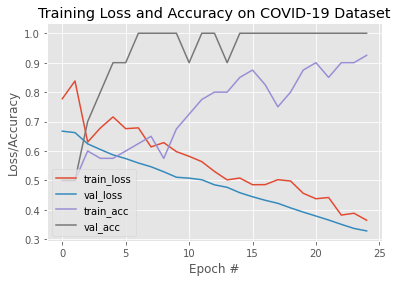

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title('Training Loss and Accuracy on COVID-19 Dataset')
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])

In [ ]:
# serialize the model to disk
print("[INFO] saving COVID-19 detector model...")
model.save(args['model'], save_format='h5')

[INFO] saving COVID-19 detector model...


# 테스트

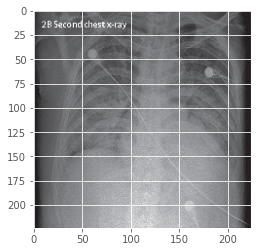

In [ ]:
# from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

args = {"model":"covid19.model", 
        "image1":"dataset/covid/lancet-case2b.jpg",
        "image2":"dataset/normal/person438_bacteria_1893.jpeg"}

# load the image
image = cv2.imread(args["image1"])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
plt.imshow(image)
plt.show()

In [ ]:
print(image.shape)
image = image.astype("float") / 255.0
image = np.array(image)
image = np.expand_dims(image, axis=0)
print(image.shape)


(224, 224, 3)
(1, 224, 224, 3)


In [ ]:
print("[INFO] loading network...")
model = load_model(args["model"])

[INFO] loading network...


In [ ]:
# classify the input image using Keras' multi-output functionality
print("[INFO] classifying image...")
categoryProba = model.predict(image)

categoryIdx = categoryProba[0].argmax()
categoryLabel = lb.classes_[categoryIdx]

# draw the category label and color label on the image
categoryText = "result: {} ({:.2f}%)".format(categoryLabel,categoryProba[0][categoryIdx] * 100)
print(categoryText)

[INFO] classifying image...
result: covid (76.59%)


In [ ]:
from google.colab import files
from tensorflow.keras.models import load_model

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (224, 224))
  plt.imshow(img)
  plt.show()

  x = img.astype('float') / 255.0
  x = np.array(x)
  x = np.expand_dims(x, axis=0)

  #
  print("[INFO] loading network...")
  model = load_model(args["model"])
  
  #
  clsProba = model.predict(x)
  clsIdx = cls[0].argmax()
  clsLabel = lb.classes_[clsIdx]
  
  # draw the category label and color label on the image
  categoryText = "category: {} ({:.2f}%)".format(clsLabel, clsProba[0][clsIdx] * 100)
  print(categoryText) 